In [1]:
from transformers import Sam3Processor, Sam3Model
import torch
from PIL import Image
from huggingface_hub import login
import numpy as np
import cv2
import matplotlib.pyplot as plt
import glob
import os
import tqdm
import random


In [9]:
## Loading model

login()

device = "cuda:3"

model = Sam3Model.from_pretrained("facebook/sam3").to(device)
processor = Sam3Processor.from_pretrained("facebook/sam3")

Loading weights:   0%|          | 0/1468 [00:00<?, ?it/s]

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



In [10]:
# VARIABLES PER RUN

# SRC_DATASET_BASE_DIR = "/home/jovyan/thesis/datasets/FLAME3/No Fire/RGB/Corrected FOV/"
# SRC_DATASET_GLOB_PATTERN = "*.JPG"

SRC_DATASET_BASE_DIR = "/home/jovyan/thesis/datasets/Bamberg_coco1024/train2023/"
SRC_DATASET_GLOB_PATTERN = "*.tif"

DST_DATASET_BASE_DIR = "/home/jovyan/thesis/datasets/custom/temp/"
DST_DATASET_IMAGE_SUBDIR = "images"
DST_DATASET_MASKS_SUBDIR = "masks"


In [11]:


def visualize_sam3_results(image, results, alpha=0.5, draw_boxes=True):

    image_np = np.array(image).copy()
    overlay = image_np.copy()

    masks = results["masks"]
    boxes = results.get("boxes", None)
    scores = results.get("scores", None)

    if len(masks) == 0:
        #print("No objects detected.")
        plt.imshow(image_np)
        plt.axis("off")
        return

    for i, mask in enumerate(masks):

        mask = mask.cpu().numpy().astype(bool)

        # Random color for each mask
        color = np.random.randint(0, 255, size=3)

        overlay[mask] = color

        # Draw bounding box
        if draw_boxes and boxes is not None:
            x1, y1, x2, y2 = boxes[i].cpu().numpy().astype(int)

            cv2.rectangle(
                overlay,
                (x1, y1),
                (x2, y2),
                color.tolist(),
                2
            )

            # Draw score label
            if scores is not None:
                label = f"{scores[i]:.2f}"
                cv2.putText(
                    overlay,
                    label,
                    (x1, max(0, y1 - 5)),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    0.5,
                    color.tolist(),
                    2
                )

    blended = cv2.addWeighted(overlay, alpha, image_np, 1 - alpha, 0)

    plt.figure(figsize=(5, 5))
    plt.imshow(blended)
    plt.axis("off")
    plt.show()
    
    plt.figure(figsize=(5, 5))
    plt.imshow(image_np)
    plt.axis("off")
    plt.show()
    
def save_sam3_results(image, results, idx, dst_image_path, dst_masks_path):
    masks = results["masks"]
    if len(masks) == 0:
        return
    image_np = np.array(image).copy()
    image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2RGB)
    image_gray = cv2.cvtColor(image_np, cv2.COLOR_RGB2GRAY)
    overlay = np.zeros_like(image_gray, dtype=np.int32)
    
    for m in masks:
        mnp = m.cpu().numpy().astype(bool)
        overlay[mnp] = 255
    
    cv2.imwrite(f"{dst_image_path}/{idx}.jpg", image_np)
    cv2.imwrite(f"{dst_masks_path}/{idx}.jpg", overlay)
    
    

In [12]:

# def run_sam3_text_inference(images:list, prompts:list, batch_size=4):
#     image_batches = []
#     for i in range(0, len(images), batch_size):
#         local_list = []
#         for j in range(batch_size):
#             local_list.append(images[i + j])
#         image_batches.append(local_list)
    
#     result_list = []
#     idx = 0
#     print("Starting batch inference")
#     for ibatch in image_batches:
#         print(f"Batch [{idx+1} / {len(image_batches)}] Started")
#         image_list = []
#         for file in ibatch:
#             image_list.append(Image.open(file).convert("RGB"))

#         inputs = processor(images=image_list, text=prompts, return_tensors="pt").to(device)
#         with torch.no_grad():
#             outputs = model(**inputs)

#         results = processor.post_process_instance_segmentation(
#             outputs,
#             threshold=0.3,
#             mask_threshold=0.5,
#             target_sizes=inputs.get("original_sizes").tolist()
#         )
#         for r in results:
#             result_list.append(r)
#         print(f"Batch [{idx+1} / {len(image_batches)}] Completed")
#     return result_list


#results = run_sam3_text_inference(file_list[:8], ["leaves", "dry trees"])

def run_inference_per_image(image, text_prompt):
    # Segment using text prompt
    inputs = processor(images=image, text=text_prompt, return_tensors="pt").to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Post-process results
    results = processor.post_process_instance_segmentation(
        outputs,
        threshold=0.2,
        mask_threshold=0.3,
        target_sizes=inputs.get("original_sizes").tolist()
    )[0]
    #print(f"Found {len(results['masks'])} objects")
    return results

# Load image

# Results contain:
# - masks: Binary masks resized to original image size
# - boxes: Bounding boxes in absolute pixel coordinates (xyxy format)
# - scores: Confidence scores

Found 7509 files in the source dataset
Making destination images dataset at /home/jovyan/thesis/datasets/custom/temp/
Making images directory
Making masks directory


 27%|██▋       | 2000/7509 [1:52:53<5:10:44,  3.38s/it]

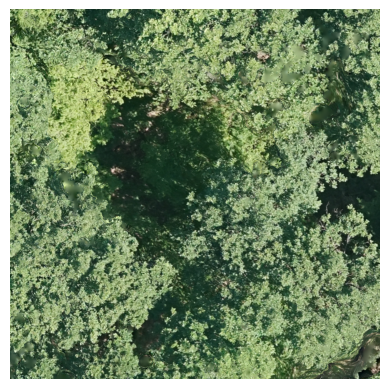

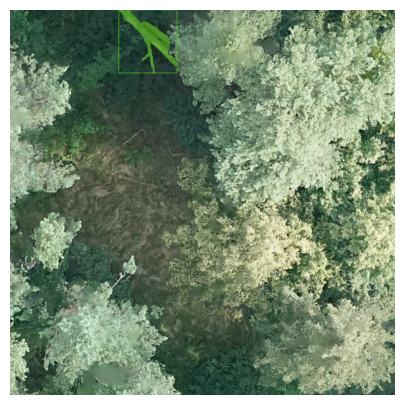

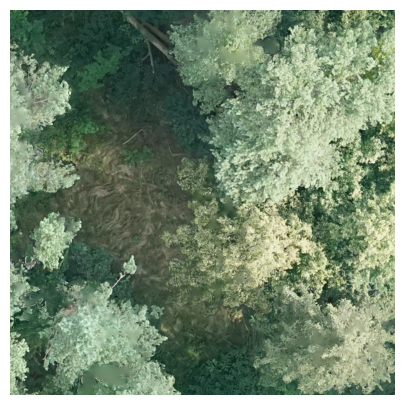

 59%|█████▊    | 4407/7509 [4:08:27<2:54:53,  3.38s/it]


KeyboardInterrupt: 

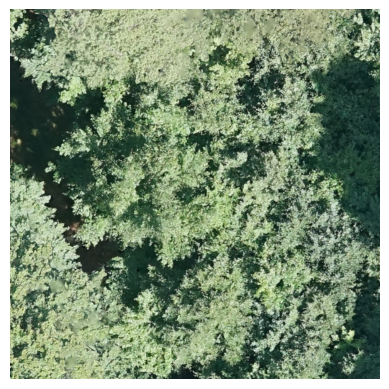

In [13]:
from PIL import ImageFile

ImageFile.LOAD_TRUNCATED_IMAGES = True

# Main inference logic
file_list = glob.glob(f"{SRC_DATASET_BASE_DIR}/{SRC_DATASET_GLOB_PATTERN}")


# and "_tropical_dry_" in f
new_file_list = []
# for f in file_list:
#     if "_RGB" in f and "_vineyard_" not in f:
#         new_file_list.append(f)
# file_list = new_file_list
random.shuffle(file_list)

print(f"Found {len(file_list)} files in the source dataset")


dst_image_path = f"{DST_DATASET_BASE_DIR}/{DST_DATASET_IMAGE_SUBDIR}"
dst_masks_path = f"{DST_DATASET_BASE_DIR}/{DST_DATASET_MASKS_SUBDIR}"

print(f"Making destination images dataset at {DST_DATASET_BASE_DIR}")
print("Making images directory")
os.makedirs(dst_image_path, exist_ok=True)
print("Making masks directory")
os.makedirs(dst_masks_path, exist_ok=True)


idx = 0

viz_every = 1000
for i in tqdm.tqdm(file_list):
    image = Image.open(i).convert("RGB")
    results = run_inference_per_image(image, "dead tree")
    
    if idx % viz_every == 0:
        visualize_sam3_results(image, results)
    save_sam3_results(image, results, idx, dst_image_path, dst_masks_path)
    idx+=1
